# Lab - Texture Analysis

## Part A

### Objective

The goal of this part is to segment the following photo into 3 segments:
1. a segment for clothes with a jeans texture
2. a segment for clothes with a cotton texture
3. a segment for the background

<img src='test.jpg' width=100px heigth=300px></img>

In [1]:
# All the imports you will need in the whole lab
from skimage.feature import graycomatrix, graycoprops
from skimage import io
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import os
import numpy as np

## Section 1

In this section, you will extract features from image samples of the jeans and cotton texture using GLCM, then we will plot our feature space to see if our features are able to differentiate between the textures of jeans, cotton, and background.

### TODO Implement get_glcm_features

You will need the following two functions:

greycomatrix, doc link -> https://scikit-image.org/docs/dev/api/skimage.feature.html#greycomatrix <br>
greycoprops, doc link -> https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycoprops

In [2]:


def get_glcm_features(gray_scale_img):
    """
    Given a grayscale image with graylevels from 0 - 255,
    return contrast and homogeneity using graycomatrix
    with ONLY the parameters stated in the lab.
    """

    # MUST be uint8 for graycomatrix
    img = gray_scale_img.astype(np.uint8)

    # Lab-specified parameters:
    # distance = 1
    # angle = 0 degrees
    # levels = 256 (gray levels 0–255)
    glcm = graycomatrix(
        img,
        distances=[1],
        angles=[0],
        levels=256,
        symmetric=False,
        normed=True
    )

    # Extract features
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    return contrast, homogeneity


The following part will extract the contrast and homogeneity of samples of jeans and cotton in the folder "imgs_patches" using your function. So, for each sample image, we will have a point in a 2D feature space. Then, it will plot this feature space.

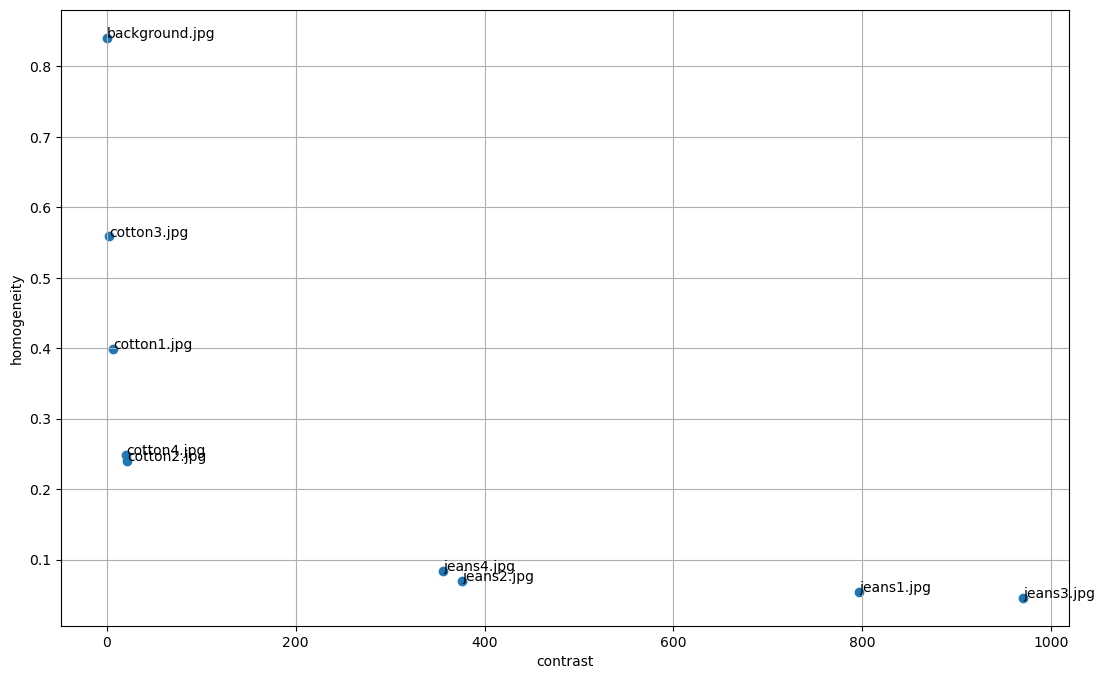

In [3]:
# You don't need to understand how this function works
def get_fname_images_tuple(directory):
    fnames = os.listdir(directory)
    to_return = []
    for fn in fnames:
        if fn[-3:] == 'jpg':
            path = os.path.join(directory, fn)
            gray_scale_image = (rgb2gray(io.imread(path)) * 255).astype(np.uint8)
            to_return.append((fn, gray_scale_image))
        else:
            print('This file has been skipped', fn)
    return to_return

# You don't need to understand how this function works
def plot_2d_features_with_names(names_fts_list, xlabel, ylabel):
    x = [names_fts[1][0] for names_fts in names_fts_list]
    y = [names_fts[1][1] for names_fts in names_fts_list]
    txts = [names_fts[0] for names_fts in names_fts_list]

    fig, ax = plt.subplots()
    ax.scatter(x, y)

    for i, txt in enumerate(txts):
        ax.annotate(txt, (x[i], y[i]))
    ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig = plt.gcf()
    fig.set_size_inches(13, 8)


fn_img_list = get_fname_images_tuple(r'imgs_patches')

fn_ft_list = []
for fn, img in fn_img_list:
    fn_ft_list.append((fn, get_glcm_features(img)))

plot_2d_features_with_names(fn_ft_list, 'contrast', 'homogeneity')

## Section 2

You should have noticed that the previous section showed us that we can differentiate between jeans, cotton, & background patches using contrast and homogeneity. So, in this section, we will classify an unknown patch into one of those categories using a simple rule-based classifier. This will make us able to segment an image.

In [7]:
def classify_patch(contrast, homogeneity):
    """
    Classifies a patch into 'jeans', 'cotton', or 'background'
    based on contrast and homogeneity values extracted from GLCM.
    """
    if homogeneity > 0.8 :
        return "background"

    if contrast > 0 and contrast<=200 and homogeneity <0.6 and homogeneity >0.2:   # Jeans typically strong contrast
        return "cotton"
    else:             
        return "jeans"


### TODO Complete todos in segment_img

This function is given an RGB image, and returns the segmented image coloring jeans patches in green, cotton patches in red, and the background in blue. Your final output should look like the following image:

<img src='target_output.jpg' width=100px heigth=300px></img>

In [10]:
def segment_img(image):
    img = image.copy()
    patch_height = patch_width = 50

    H, W, _ = img.shape

    # Loop patch by patch
    for row in range(0, H, patch_height):
        for col in range(0, W, patch_width):
            patch = img[row:row+patch_height, col:col+patch_width]
            patch_grayscale = (rgb2gray(patch) * 255).astype(np.uint8)
            contrast, homogeneity = get_glcm_features(patch_grayscale)
            classification = classify_patch(contrast, homogeneity)
            if classification == 'cotton':
                patch[:, :, 0] = 255      
            elif classification == 'jeans':
                patch[:, :, 1] = 255       
            else:
                patch[:, :, 2] = 255       

    return img

C:\Users\IMEDIA\AppData\Local\Temp\ipykernel_19672\603554719.py:4: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(segmented_image)


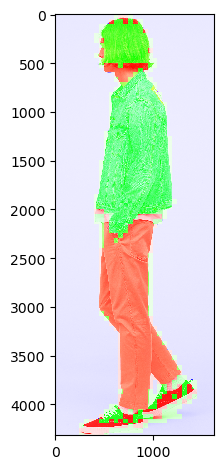

In [11]:
# Testing your work
image = io.imread('test.jpg')
segmented_image = segment_img(image)
io.imshow(segmented_image)

## Part B

You are required to implement your own function that computes the LBP histogram of a grayscale image (return to lecture slides for reference attached in this lab folder).

#### Note: you are allowed to ignore image border pixels.

In [ ]:
import numpy as np

def get_lbp_hist(grayscale_img):
    """
    Computes the LBP histogram (256 bins) of a grayscale image.
    Border pixels are ignored.
    """

    img = grayscale_img.astype(np.uint8)
    H, W = img.shape

    # histogram for 8-bit patterns → 256 bins
    hist = np.zeros(256, dtype=int)

    # Offsets of the 8 neighbors (clockwise)
    neighbors = [
        (-1, -1),  # top-left
        (-1,  0),  # top
        (-1,  1),  # top-right
        ( 0,  1),  # right
        ( 1,  1),  # bottom-right
        ( 1,  0),  # bottom
        ( 1, -1),  # bottom-left
        ( 0, -1)   # left
    ]

    # Ignore borders → range starts from 1 to H-2, W-2
    for y in range(1, H-1):
        for x in range(1, W-1):

            center = img[y, x]
            lbp_code = 0

            # Build the 8-bit LBP pattern
            for i, (dy, dx) in enumerate(neighbors):
                neighbor_value = img[y + dy, x + dx]

                # Your rule:
                # bit = 0 if neighbor < center
                # bit = 1 otherwise
                bit = 1 if neighbor_value >= center else 0

                # place bit at position i
                lbp_code |= (bit << i)

            # increment histogram bin
            hist[lbp_code] += 1

    return hist


'ignore function output'

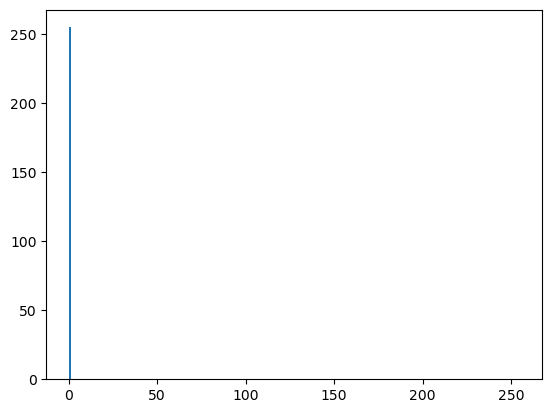

In [16]:
# Testing your work, we will compare your histogram with that of ours
# There should be a noticable difference between the histograms of jeans and cotton
img = rgb2gray(io.imread(r'imgs_patches\jeans1.jpg'))
hist = get_lbp_hist(img)
plt.hist(hist, bins=range((2 ** 8)))
'ignore function output'

'ignore function output'

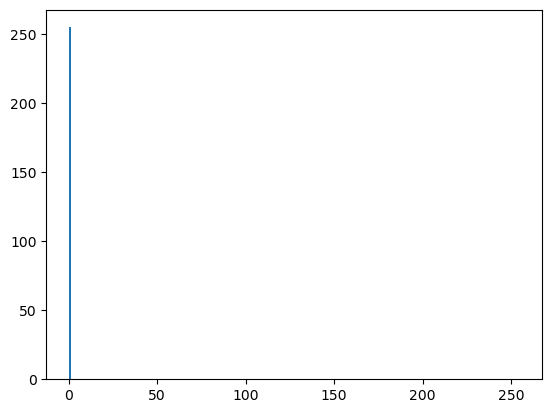

In [17]:
# Testing your work, we will compare your histogram with that of ours
# There should be a noticable difference between the histograms of jeans and cotton
img = rgb2gray(io.imread(r'imgs_patches\cotton1.jpg'))
hist = get_lbp_hist(img)
plt.hist(hist, bins=range((2 ** 8)))
'ignore function output'